In [5]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cPickle
import os
import gzip
import csv
import seaborn as sns
import math
import random

import matplotlib as mpl
if float(mpl.__version__[:3]) >= 1.5:
    %matplotlib notebook
else:
    %matplotlib inline
    

# First exercise: Classifying MNIST with MLPs
In this exercise you will implement a Neural Network (or MLP) and classify the MNIST digits with it.
MNIST is a "well hung" dataset that has been used a lot over the years to benchmark different classification algorithms. 
To learn more about it have a look here: http://yann.lecun.com/exdb/mnist/ .

# Data Loading
We first define a function for downloading and loading MNIST.
**WARNING**: Executing it will obviously use up some space on your machine ;). 

In [6]:
def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = cPickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = cPickle.load(f)
    f.close()
     
        
    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
    print('... done loading data')
    return rval, test_set



# Neural Network Layers
We now define "bare bone" neural network layers.
The parts marked with **TODO** are where you should finish the implementation!
Conceptually we will implement the layers as follows:

Each layer has a constructor that takes an input layer plus some additional arguments such as layer size and the activation function name. The layer then uses the provided input layer to compute the layer dimensions, weight shapes, etc. and setup all auxilliary variables.

Each layer then has to provide three functions (as defined in the Layer class below): *output_shape()*, *fprop()* and *brop()*. The output_shape function is used to figure out the shape for the next layer and the *fprop()/bprop()* functions are used to compute forward and backward passes through the network.

In [7]:
# start by defining simple helpers
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def sigmoid_d(x):
    return sigmoid(x)*(1-sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    return 1.0 - tanh(x)**2

def relu(x):
    return np.maximum(0.0, x)

def relu_d(x):
    dx = np.zeros_like(x)
    dx[x > 0] = 1.
    return dx

def softmax(x, axis=1):
    # to make the softmax a "safe" operation we will 
    # first subtract the maximum along the specified axis
    # so that np.exp(x) does not blow up!
    # Note that this does not change the output.
    x_max = np.max(x, axis=axis, keepdims=True)
    x_safe = x - x_max
    e_x = np.exp(x_safe)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels

def unhot(one_hot_labels):
    """ Invert a one hot encoding, creating a flat vector """
    return np.argmax(one_hot_labels, axis=-1)

# then define an activation function class
class Activation(object):
    
    def __init__(self, tname):
        if tname == 'sigmoid':
            self.act = sigmoid
            self.act_d = sigmoid_d
        elif tname == 'tanh':
            self.act = tanh
            self.act_d = tanh_d
        elif tname == 'relu':
            self.act = relu
            self.act_d = relu_d
        else:
            raise ValueError('Invalid activation function.')
      
    def dropout(self, input, keep_prob=0.5):
        dim1 = np.random.rand(input.shape[0])
        dim2 = np.ones_like(input.shape[1])
        dropout = np.random.rand(input.shape[0], input.shape[1])
        dropout = dropout < keep_prob
        input = np.multiply(input, dropout)
        input = input / keep_prob
        return input
     
    
    def fprop(self, input, dropout):
        # we need to remember the last input
        # so that we can calculate the derivative with respect
        # to it later on
        if dropout:
            self.last_input = self.dropout(input)
        else:
            self.last_input = input
        return self.act(input)
    
    def bprop(self, output_grad):
        return output_grad * self.act_d(self.last_input)

# define a base class for layers
class Layer(object):
    
    def fprop(self, input, dropout=False):
        """ Calculate layer output for given input 
            (forward propagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def bprop(self, output_grad):
        """ Calculate input gradient and gradient 
            with respect to weights and bias (backpropagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def output_size(self):
        """ Calculate size of this layer's output.
        input_shape[0] is the number of samples in the input.
        input_shape[1:] is the shape of the feature.
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a base class for loss outputs
# an output layer can then simply be derived
# from both Layer and Loss 
class Loss(object):

    def loss(self, output, output_net):
        """ Calculate mean loss given real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def input_grad(self, output, output_net):
        """ Calculate input gradient real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a base class for parameterized things        
class Parameterized(object):
    
    def params(self):
        """ Return parameters (by reference) """
        raise NotImplementedError('This is an interface class, please use a derived instance')
    
    def grad_params(self):
        """ Return accumulated gradient with respect to params. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a container for providing input to the network
class InputLayer(Layer):
    
    def __init__(self, input_shape):
        if not isinstance(input_shape, tuple):
            raise ValueError("InputLayer requires input_shape as a tuple")
        self.input_shape = input_shape

    def output_size(self):
        return self.input_shape
    
    def fprop(self, input, dropout):
        return input
    
    def bprop(self, output_grad):
        return output_grad
        
class FullyConnectedLayer(Layer, Parameterized):
    """ A standard fully connected hidden layer, as discussed in the lecture.
    """
    
    def __init__(self, input_layer, num_units, 
                 init_stddev, activation_fun=Activation('relu')):
        self.num_units = num_units
        self.activation_fun = activation_fun
        # the input shape will be of size (batch_size, num_units_prev) 
        # where num_units_prev is the number of units in the input 
        # (previous) layer
        self.input_shape = input_layer.output_size()
        
        # this is the weight matrix it should have shape: (num_units_prev, num_units)
        self.W = np.random.normal(loc=0.0, scale=init_stddev, size=(self.input_shape[1], num_units))
        # and this is the bias vector of shape: (num_units)
        self.b = np.random.normal(loc=0.0, scale=init_stddev, size=(num_units,))
        
        self.dW = None
        self.db = None
    
    def output_size(self):
        return (self.input_shape[0], self.num_units)
    
    def fprop(self, input, dropout):

        self.last_input = input.copy()
        
        #print('w.shape', self.W.shape,
        #     'input.shape', input.shape,
        #      'b.shape', self.b.shape)
        
        a = np.dot(input, self.W) + self.b
        
        if self.activation_fun == None:
            return a
        else:
            return self.activation_fun.fprop(a, dropout)
        
    def bprop(self, output_grad):
        """ Calculate input gradient (backpropagation). """
        # HINT: you may have to divide dW and db by n
        #       to make gradient checking work 
        #       OR you divide the gradient in the output layer by n
        n = output_grad.shape[0]
        # accumulate gradient wrt. the parameters first
        # we will need to store these to later update
        # the network after a few forward backward passes
        
        if self.activation_fun == None:
            act_grad = output_grad
        else:
            act_grad = self.activation_fun.bprop(output_grad)
            
        self.dW = np.dot(self.last_input.T, act_grad)
        self.db = np.sum(act_grad, axis=0)
        
        #print('dW.shape', self.dW.shape,'db.shape', self.db.shape)
        
        grad_input = act_grad.dot(self.W.T)
        return grad_input
        
    def params(self):
        return self.W, self.b

    def grad_params(self):
        return self.dW, self.db

# finally we specify the interface for output layers 
# which are layers that also have a loss function
# we will implement two output layers:
#  a Linear, and Softmax (Logistic Regression) layer
# The difference between output layers and and normal 
# layers is that they will be called to compute the gradient
# of the loss through input_grad(). bprop will never 
# be called on them!
class LinearOutput(Layer, Loss):
    """ A simple linear output layer that  
        uses a squared loss (e.g. should be used for regression)
    """
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
        
    def fprop(self, input, dropout):
        return input

    def bprop(self, output_grad):
        raise NotImplementedError(
            'LinearOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):                  
        n_samples = Y.shape[0]
        return (Y_pred - Y) / n_samples        

    def loss(self, Y, Y_pred, l2='no', lamdb=1):
        if l2 == 'yes':
            loss = 0.5 * np.square(Y_pred - Y) + np.sum(np.square(self.W))*(lambd/2)
        else:
            loss = 0.5 * np.square(Y_pred - Y)
        print(loss.shape)
        print(self.W.shape)
        return np.mean(np.sum(loss, axis=1))

class SoftmaxOutput(Layer, Loss):
    """ A softmax output layer that calculates 
        the negative log likelihood as loss
        and should be used for classification.
    """
    
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
    
    def fprop(self, input, dropout):
        return softmax(input)
    
    def bprop(self, output_grad):
        raise NotImplementedError(
            'SoftmaxOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
        # HINT: since this would involve taking the log 
        #       of the softmax (which is np.exp(x)/np.sum(x, axis=1))
        #       this gradient computation can be simplified a lot,
        #       you may find a connection to the LinearOutput layer!
        n_samples = Y.shape[0]
        #print('Y.shape:{}   Y_pred.shape: {}'.format(Y.shape, Y_pred.shape))
        return (Y_pred - Y) / Y.shape[0]

    def loss(self, Y, Y_pred, lamdb='no'):
        # Assume one-hot encoding of Y
        out = Y_pred
        # to make the loss numerically stable 
        # you should add an epsilon in the log ;)
        eps = 1e-10
        # TODO ####################################
        # calculate negative log likelihood
        # TODO ####################################
        if lamdb =='yes':
            loss = np.sum(-np.log(Y_pred+eps)*Y, axis=1) + np.sum(np.square(self.W))*(lambd/2)
        else:
            loss = np.sum(-np.log(Y_pred+eps)*Y, axis=1)
            
        return np.mean(loss)
        

# Neural Network class
With all layers in place (and properly implemented by you) we can finally define a neural network.
For our purposes a neural network is simply a collection of layers which we will cycle through and on which we will call fprop and bprop to compute partial derivatives with respect to the input and the parameters.

Pay special attention to the *check_gradients()* function in which you should implement automatic differentiation. This function will become your best friend when checking the correctness of your implementation.

In [74]:

class NeuralNetwork:
    """ Our Neural Network container class.
    """
    def __init__(self, layers):
        self.layers = layers
        self.fig = 0
        self.ax = 0
        self.V_dW = [0 for _ in range(len(self.layers))]
        self.V_db = [0 for _ in range(len(self.layers))]
        
    def _loss(self, X, Y, dropout, l2='no'):
        Y_pred = self.predict(X, dropout)
        return self.layers[-1].loss(Y, Y_pred, l2)

    def predict(self, X, dropout):
        """ Calculate an output Y for the given input X. """
        new_input = X
        for layer in self.layers:
            new_input = layer.fprop(new_input, dropout)
        return new_input
    
    def backpropagate(self, Y, Y_pred, upto=0):
        """ Backpropagation of partial derivatives through 
            the complete network up to layer 'upto'
        """
        
        next_input = self.layers[-1].input_grad(Y, Y_pred)
        
        backwards = np.flip(range(upto, len(self.layers)-1), axis=0)
        
        for i in backwards:
            next_input = self.layers[i].bprop(next_input)
        return next_input
    
    def classification_error(self, X, Y):
        """ Calculate error on the given data 
            assuming they are classes that should be predicted. 
        """
        Y_pred = unhot(self.predict(X, dropout=False))
        error = Y_pred != Y
        return np.mean(error)
    

    def sgd_momentum_epoch(self, X, Y, learning_rate, batch_size, dropout, beta=0.9):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        idx = np.arange(0, n_samples)
        for b in range(n_batches):
            X_batch = X[b*batch_size:(b+1)*batch_size]
            Y_batch = Y[b*batch_size:(b+1)*batch_size]
            
            prediction = self.predict(X_batch, dropout)
            self.backpropagate(Y_batch, prediction)

        for l, layer in enumerate(self.layers):
            if isinstance(layer, Parameterized):
                self.V_dW[l] = beta * self.V_dW[l] +  (1-beta) * layer.dW
                self.V_db[l] = beta * self.V_db[l] +  (1-beta) * layer.db
                layer.W -= learning_rate * self.V_dW[l]
                layer.b -= learning_rate * self.V_db[l]
        
    
    def sgd_epoch(self, X, Y, learning_rate, batch_size, dropout):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        idx = np.arange(0, n_samples)
        for b in range(n_batches):
            X_batch = X[b*batch_size:(b+1)*batch_size]
            Y_batch = Y[b*batch_size:(b+1)*batch_size]
            
            prediction = self.predict(X_batch, dropout)
            self.backpropagate(Y_batch, prediction)
            
            for layer in self.layers:
                if isinstance(layer, Parameterized):
                    layer.W -= learning_rate * layer.dW
                    layer.b -= learning_rate * layer.db

                    
    def gd_epoch(self, X, Y, dropout):
        # TODO ##################################################
        # Implement batch gradient descent here
        # A few hints:
        #   There are two strategies you can follow:
        #   Either shove the whole dataset throught the network
        #   at once (which can be problematic for large datasets)
        #   or run through it batch wise as in the sgd approach
        #   and accumulate the gradients for all parameters as
        #   you go through the data. Either way you should then
        #   do one gradient step after you went through the
        #   complete dataset!
        # TODO ##################################################
        prediction = self.predict(X, dropout)
        self.backpropagate(Y, prediction)
        
        for layer in self.layers:
            if isinstance(layer, Parameterized):
                layer.W = -learning_rate * layer.dW
                layer.b = -learning_rate * layer.db

    def plot_loss(self, ax, fig, training_loss, valid_loss):
        if self.ax.lines:
            self.ax.lines[0].set_ydata(training_loss)
            self.ax.lines[1].set_ydata(valid_loss)
            #self.ax.set_ylim([0,  0.2])
            self.ax.set_ylim([0,  max(max(training_loss), max((valid_loss)))])
        else:
            self.ax.plot(training_loss, c='b', label='Training loss')
            self.ax.plot(valid_loss, c='m', label='Validation loss')
            self.ax.legend(loc='lower left')
        self.fig.canvas.draw()


    def train(self, X, Y, X_valid, Y_valid, learning_rate=0.1, max_epochs=100,
              batch_size=64,
              descent_type="sgd", y_one_hot=True, dropout=False, l2='no'):
        
        training_loss = np.ones(max_epochs+1) * np.nan
        valid_loss = np.ones(max_epochs+1) * np.nan
        
        """Plotting"""
        update_plot = 1
        self.fig, self.ax = plt.subplots(1, 1)
        self.ax.set_title('Training progress')
        self.ax.set_xlim([0, max_epochs+1])
        self.ax.set_ylim([0, 1])
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Error')
        
        """ Train network on the given data. """
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        if y_one_hot:
            Y_train = one_hot(Y)
            Y_validOneHot = one_hot(Y_valid)
            print(Y_validOneHot.shape)
        else:
            Y_train = Y
            Y_validOneHot = Y_valid
        print("... starting training")
        #print('training loss:', training_loss, training_loss.shape)
        for i in range(max_epochs+1):
            if descent_type == "sgd":
                if i > 50000:
                    self.sgd_epoch(X, Y_train, 0.5, batch_size, dropout)
                else:
                    self.sgd_epoch(X, Y_train, learning_rate, batch_size, dropout)
            elif descent_type == "gd":
                self.gd_epoch(X, Y_train, learning_rate, dropout)
                
            elif descent_type == "sgd_momentum":
                self.sgd_momentum_epoch(X, Y_train, learning_rate, batch_size, dropout)
            else:
                raise NotImplementedError("Unknown gradient descent type {}".format(descent_type))
            
            
            # Output error on the training data
            training_loss[i] = self._loss(X, Y_train, l2, dropout)
            train_error = self.classification_error(X, Y)
             
            valid_loss[i] = self._loss(X_valid, Y_validOneHot, dropout)
            valid_error = self.classification_error(X_valid, Y_valid)
            
            if i % update_plot == 0 or i == max_epochs - 1:
                self.plot_loss(self.ax, self.fig, training_loss, valid_loss)
            
            print('epoch {:.4f}, loss {:.4f}, train error {:.4f}, valid_loss {:.4f}, valid_error{:.4f}'.format(i, training_loss[i], train_error, valid_loss[i], valid_error))
            #print('epoch {:.4f}, loss {:.4f}, train error {:.4f}, valid_loss {:.4f}, valid_error{:.4f}'.format(e, train_loss, train_error, valid_loss, valid_error))
            #print('epoch {:.4f}, loss {:.4f}, train error {:.4f}'.format(e, train_loss, train_error))


    def check_gradients(self, X, Y, dropout):
        """ Helper function to test the parameter gradients for
        correctness. """
        for l, layer in enumerate(self.layers):
            if isinstance(layer, Parameterized):
                print('checking gradient for layer {}'.format(l))
                for p, param in enumerate(layer.params()):
                    # we iterate through all parameters
                    param_shape = param.shape
                    # define functions for conveniently swapping
                    # out parameters of this specific layer and 
                    # computing loss and gradient with these 
                    # changed parametrs
                    def output_given_params(param_new):
                        """ A function that will compute the output 
                            of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # return computed loss
                        return self._loss(X, Y, dropout=False)

                    def grad_given_params(param_new):
                        """A function that will compute the gradient 
                           of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # Forward propagation through the net
                        Y_pred = self.predict(X, dropout=False)
                        # Backpropagation of partial derivatives
                        self.backpropagate(Y, Y_pred, upto=l)
                        # return the computed gradient 
                        return np.ravel(self.layers[l].grad_params()[p])

                    # let the initial parameters be the ones that
                    # are currently placed in the network and flatten them
                    # to a vector for convenient comparisons, printing etc.
                    param_init = np.ravel(np.copy(param))
                    
                    # To debug you network's gradients use scipys
                    # gradient checking!
                    epsilon = 1e-5
                    #epsilon = 5
                    import scipy.optimize
                    err = scipy.optimize.check_grad(output_given_params, 
                          grad_given_params, param_init) 
                    print('diff scipy {:.2e}'.format(err))
                    #print('err:', err)
                    assert(err < epsilon)
                    
                    # reset the parameters to their initial values
                    param[:] = np.reshape(param_init, param_shape)
            

# Gradient Checking
After implementing everything it is always a good idea to setup some layers and perform gradient
checking on random data. **Note** that this is only an example! It is not a useful network architecture ;). We also expect you to play around with this to test all your implemented components.

In [67]:
input_shape = (5, 10)
n_labels = 6
layers = [InputLayer(input_shape)]

layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=15,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=6,
                init_stddev=0.1,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=n_labels,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(SoftmaxOutput(layers[-1]))
nn = NeuralNetwork(layers)

In [68]:
# create random data
X = np.random.normal(size=input_shape)
# and random labels
Y = np.zeros((input_shape[0], n_labels))
for i in range(Y.shape[0]):
    idx = np.random.randint(n_labels)
    Y[i, idx] = 1.

In [69]:
nn.check_gradients(X, Y, dropout=True)

checking gradient for layer 1
diff scipy 1.53e-07
diff scipy 4.00e-08
checking gradient for layer 2
diff scipy 1.19e-07
diff scipy 6.31e-08
checking gradient for layer 3
diff scipy 6.41e-08
diff scipy 2.74e-08


# Training on MNIST
Finally we can let our network run on the MNIST dataset!

First load the data and reshape it.

In [10]:
# load
(Dtrain, Dval, Dtest), test_set_vis = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval



... loading data
... done loading data


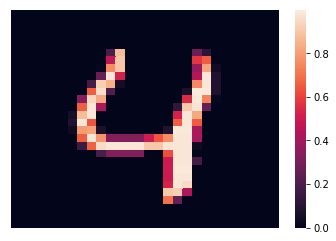

In [11]:
"""visualize single elements of mnist dataset"""

def visualize_mnist(train_set, id):
    _, D = train_set[0].shape
    W = int(math.sqrt(D))
    plt.figure()
    sns.heatmap(np.reshape(train_set[0][id], (W, W)), linewidth=0, xticklabels=False, yticklabels=False)

# visualizing 6th element
visualize_mnist(test_set_vis, 4)



*Dtrain* contains 50k images which are of size 28 x 28 pixels. Hence:

In [12]:
print("X_train shape: {}".format(np.shape(X_train)))
print("y_train shape: {}".format(np.shape(y_train)))


X_train shape: (50000, 1, 28, 28)
y_train shape: (50000,)


y_train will automatically be converted in the *train()* function to one_hot encoding.


But we need to reshape X_train, as our Network expects flat vectors of size 28*28 as input!

In [13]:
X_train = X_train.reshape(X_train.shape[0], -1)
print("Reshaped X_train size: {}".format(X_train.shape))
X_valid = X_valid.reshape((X_valid.shape[0], -1))
print("Reshaped X_valid size: {}".format(X_valid.shape))

Reshaped X_train size: (50000, 784)
Reshaped X_valid size: (10000, 784)


Ah, much better ;-)! 

Now we can finally really start training a Network!


I pre-defined a small Network for you below. Again This is not really a good default and will not produce state of the art results. Please play around with this a bit. See how different activation functions and training procedures (gd / sgd) affect the result.

(10000, 10)
... starting training


KeyboardInterrupt: 

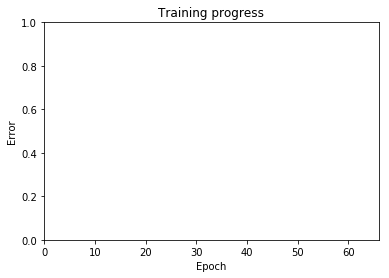

In [76]:
import time

# Setup a small MLP / Neural Network
# we can set the first shape to None here to indicate that
# we will input a variable number inputs to the network
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]


layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=250,
                init_stddev=0.01,
                activation_fun=Activation('sigmoid')
))

layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=100,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))



layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))

layers.append(SoftmaxOutput(layers[-1]))

nn = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
#print(y_valid.shape, y_train.shape)
nn.train(X_train, y_train, X_valid, y_valid, learning_rate=0.1, 
         max_epochs=65, batch_size=64, y_one_hot=True, dropout=False, l2='no')
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

# Figure out a reasonable Network that achieves good performance
As the last part of this task, setup a network that works well and gets reasonable accuracy, say ~ 1-3 percent error on the **validation set**. 
Train this network on the complete data and compute the **test error**. 

Visualize the validation loss and training loss for each iteration in a plot, e.g. using matplotlib

In [184]:
X_test, y_test = Dtest
X_test = X_test.reshape(X_test.shape[0], -1)
print(y_test.shape)
test_error = nn.classification_error(X_test, y_test)
print(test_error)

(10000,)
0.0231
